# Raw Data

```python
def make_data(
    has_spaceship: bool = None,
    noise_level: float = 0.8,
    no_lines: int = 6,
    image_size: int = 200,
) -> Tuple[np.ndarray, np.ndarray]:
    """ Data generator

    Args:
        has_spaceship (bool, optional): Whether a spaceship is included. Defaults to None (randomly sampled).
        noise_level (float, optional): Level of the background noise. Defaults to 0.8.
        no_lines (int, optional): No. of lines for line noise. Defaults to 6.
        image_size (int, optional): Size of generated image. Defaults to 200.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Generated Image and the corresponding label
        The label parameters are x, y, yaw, x size, and y size respectively
        An empty array is returned when a spaceship is not included.
    """
```

In [5]:
from helpers import make_data

In [19]:
img, label = make_data() # when has_spaceship is not given, it will have an 80% chance to create a spaceship
print(label)
print()
print(img.shape, img.dtype)
print()
print(img)

[116.         109.           4.14270141  28.          42.39768717]

(200, 200) float64

[[0.40014956 0.04581891 0.00239808 ... 0.42050319 0.7831158  0.21819837]
 [0.3925879  0.18576998 0.55716851 ... 0.71265647 0.67131695 0.13971749]
 [0.27917339 0.35908381 0.58187639 ... 0.28222641 0.1533227  0.69836159]
 ...
 [0.47442359 0.54879976 0.54100676 ... 0.40673692 0.65047657 0.24669846]
 [0.72620093 0.33291073 0.3910639  ... 0.3630842  0.66379102 0.74964678]
 [0.46728666 0.51922606 0.05323476 ... 0.34201916 0.68427936 0.79171688]]


In [20]:
img, label = make_data(has_spaceship=False)
print(label)
print()
print(img.shape, img.dtype)
print()
print(img)

[nan nan nan nan nan]

(200, 200) float64

[[0.09860741 0.58652699 0.19723894 ... 0.46635856 0.68541284 0.61183353]
 [0.43833704 0.25562477 0.00483721 ... 0.54684515 0.16197883 0.59067374]
 [0.11174275 0.66132579 0.21018074 ... 0.39412913 0.74775579 0.24305818]
 ...
 [0.62690372 0.28755905 0.10899987 ... 0.03272769 0.07257755 0.14471095]
 [0.67043387 0.73963526 0.55306874 ... 0.33030342 0.11872555 0.57659506]
 [0.34221628 0.64753078 0.33089639 ... 0.14737006 0.61813428 0.14862699]]


In [21]:
img, label = make_data(has_spaceship=True)
print(label)
print()
print(img.shape, img.dtype)
print()
print(img)

[ 23.         159.           4.60407186  30.          46.30834152]

(200, 200) float64

[[0.24414377 0.36278834 0.25843583 ... 0.64224901 0.69557267 0.5955643 ]
 [0.21770667 0.51714288 0.26541442 ... 0.38987048 0.73239237 0.60267381]
 [0.78880874 0.52747676 0.2454355  ... 0.2216314  0.27617399 0.27120619]
 ...
 [0.03729535 0.24553133 0.23237661 ... 0.56077563 0.08315135 0.23034274]
 [0.70869172 0.46174772 0.18059273 ... 0.54907801 0.64739483 0.62336908]
 [0.37884303 0.67012833 0.11137202 ... 0.70181977 0.43714005 0.08181407]]


# Visualizing

In [3]:
from helpers import make_data, _make_box_pts
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import line

In [4]:
def plot(ax, img, label, title, make_dot=True, make_box=True):
    ax.imshow(img, cmap="gray")
    ax.set_title(title)

    if label.size > 0:
        x, y, yaw, x_size, y_size = label

        if make_dot:
            ax.scatter(x, y, c="r")

        if make_box:
            xy = _make_box_pts(*label)
            ax.plot(xy[:, 0], xy[:, 1], c="r")

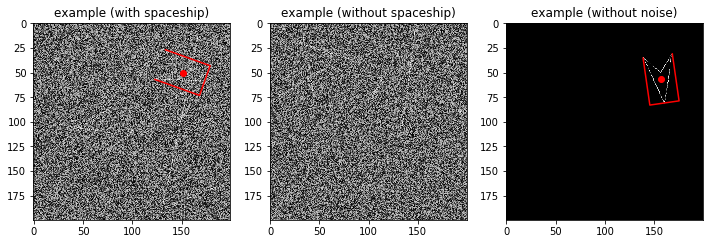

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

img, label = make_data(has_spaceship=True)
plot(ax[0], img, label, "example (with spaceship)")

img, label = make_data(has_spaceship=False)
plot(ax[1], img, label, "example (without spaceship)")

img, label = make_data(has_spaceship=True, no_lines=0, noise_level=0)
plot(ax[2], img, label, "example (without noise)")

# Component Analysis

In [1]:
import numpy as np
from skimage.draw import polygon_perimeter, line
from shapely.geometry import Polygon
from typing import Tuple, Optional


def _rotation(pts: np.ndarray, theta: float) -> np.ndarray:
    r = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    pts = pts @ r
    return pts


def _make_box_pts(
    pos_x: float, pos_y: float, yaw: float, dim_x: float, dim_y: float
) -> np.ndarray:

    hx = dim_x / 2
    hy = dim_y / 2

    pts = np.asarray([(-hx, -hy), (-hx, hy), (hx, hy), (hx, -hy)])
    pts = _rotation(pts, yaw)
    pts += (pos_x, pos_y)
    return pts


def _make_spaceship(
    pos: np.asarray, yaw: float, scale: float, l2w: float, t2l: float
) -> Tuple[np.ndarray, np.ndarray]:

    dim_x = scale
    dim_y = scale * l2w

    # spaceship
    x1 = (0, dim_y)
    x2 = (-dim_x / 2, 0)
    x3 = (0, dim_y * t2l)
    x4 = (dim_x / 2, 0)
    pts = np.asarray([x1, x2, x3, x4])
    pts[:, 1] -= dim_y / 2

    # rotation + translation
    pts = _rotation(pts, yaw)
    pts += pos

    # label
    # pos_y, pos_x, yaw, dim_x, dim_y
    params = np.asarray([*pos, yaw, dim_x, dim_y])

    return pts, params


def _get_pos(s: float) -> np.ndarray:
    return np.random.randint(10, s - 10, size=2)


def _get_yaw() -> float:
    return np.random.rand() * 2 * np.pi


def _get_size() -> int:
    return np.random.randint(18, 37)


def _get_l2w() -> float:
    return abs(np.random.normal(3 / 2, 0.2))


def _get_t2l() -> float:
    return abs(np.random.normal(1 / 3, 0.1))


In [2]:
def make_data_v2(
    has_spaceship: bool = None,
    noise_level: float = 0.8,
    no_lines: int = 6,
    image_size: int = 200,
):
    if has_spaceship is None:
        has_spaceship = np.random.choice([True, False], p=(0.8, 0.2))

    img = np.zeros(shape=(image_size, image_size))
    label = np.full(5, np.nan)

    # draw ship
    if has_spaceship:

        params = (_get_pos(image_size), _get_yaw(), _get_size(), _get_l2w(), _get_t2l())
        pts, label = _make_spaceship(*params)

        rr, cc = polygon_perimeter(pts[:, 0], pts[:, 1])
        valid = (rr >= 0) & (rr < image_size) & (cc >= 0) & (cc < image_size)

        img[rr[valid], cc[valid]] = np.random.rand(np.sum(valid))
    
    # noise lines
    line_noise = np.zeros(shape=(image_size, image_size))
    for _ in range(no_lines):
        rr, cc = line(*np.random.randint(0, 200, size=4))
        line_noise[rr, cc] = np.random.rand(rr.size)

    # static noise
    noise = noise_level * np.random.rand(image_size, image_size)
    images = {
        "spaceship": img.T,
        "noise": noise.T,
        "lines": line_noise.T,
        "noise+lines": np.stack([noise, line_noise], axis=0).max(axis=0).T,
        "spaceship+lines": np.stack([img, line_noise], axis=0).max(axis=0).T,
        "spaceship+noise": np.stack([img, noise], axis=0).max(axis=0).T,
        "img": np.stack([img, noise, line_noise], axis=0).max(axis=0).T,
    }

    return images, label

In [6]:
images, label = make_data_v2(has_spaceship=True)
for i, k in enumerate(["x", "y", "yaw", "width", "height"]):
    print(f"{k}:\t{str(round(label[i], 2))}")

x:	42.0
y:	37.0
yaw:	0.17
width:	35.0
height:	48.01


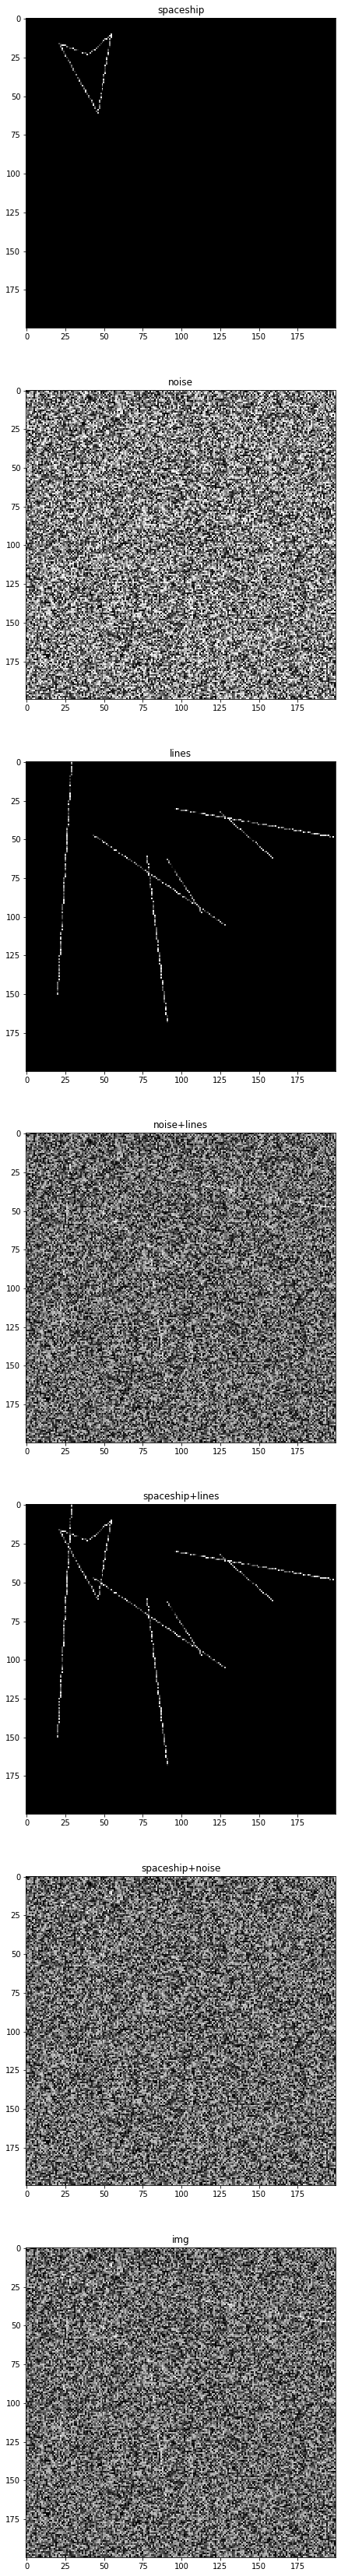

In [7]:
fig, ax = plt.subplots(len(images), 1, figsize=(16, 60))
for i, (title, img) in enumerate(images.items()):
    plot(ax[i], img, label, title, make_box=False, make_dot=False)